In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.integrate import solve_ivp

In [2]:
def lorenz(t, state, rho, sigma, beta):
    x, y, z = state
    dx_dt = sigma*(y - x)
    dy_dt = x*(rho - z) - y
    dz_dt = x*y - beta*z
    return [dx_dt, dy_dt, dz_dt]

In [3]:
# L63 parameters (chaotic regime)
rho0 = 28
sigma0 = 10
beta0 = 8/3

# rho = 28
# sigma = 10
# beta = 8/3

# N = 1000
# epsilon = 0.05
# K = 0.5

In [4]:
t_span = (0, 10000)
t_eval = np.linspace(*t_span, 5000000)
x0 = [1.0, 1.0, 1.0]

In [8]:
dt = t_eval[1] - t_eval[0]
dt

0.00200000040000008

### Run the model

In [9]:
t_span = (0, 10000)
t_eval = np.linspace(*t_span, 5000000)
x0 = [1.0, 1.0, 1.0]

sol = solve_ivp(lorenz, t_span, x0, t_eval=t_eval, args=(rho0, sigma0, beta0,))
x, y, z = sol.y

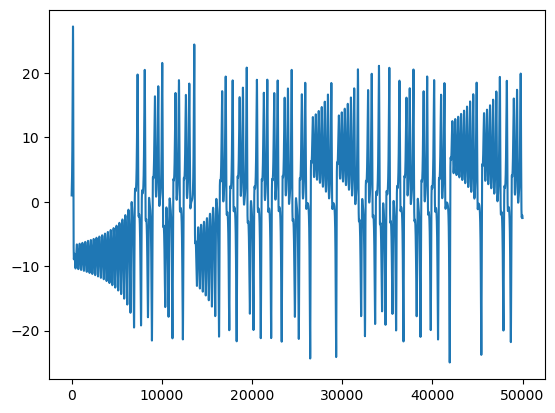

In [11]:
plt.plot(y[:50000])

### Find 2D map

In [15]:
def Poincare_Map(y_plane, x, y, z):
    # Extract points where y crosses y_plane from below (Poincaré section)
    poincare_points = []
    for i in range(1, len(y)):
        if (y[i-1] - y_plane) < 0 and (y[i] - y_plane) >= 0:
            # Linear interpolation to find intersection more accurately
            alpha = (y_plane - y[i-1]) / (y[i] - y[i-1])
            x_cross = x[i-1] + alpha * (x[i] - x[i-1])
            z_cross = z[i-1] + alpha * (z[i] - z[i-1])
            poincare_points.append([x_cross, z_cross])
    poincare_points = np.array(poincare_points)   
    
    return poincare_points

In [16]:
poincare_points_0 = Poincare_Map(0, x, y, z)
poincare_points_p10 = Poincare_Map(10, x, y, z)
poincare_points_m10 = Poincare_Map(-10, x, y, z)

In [17]:
xp_0 = poincare_points_0[:,0]
zp_0 = poincare_points_0[:,1]

xp_p10 = poincare_points_p10[:,0]
zp_p10 = poincare_points_p10[:,1]

xp_m10 = poincare_points_m10[:,0]
zp_m10 = poincare_points_m10[:,1]

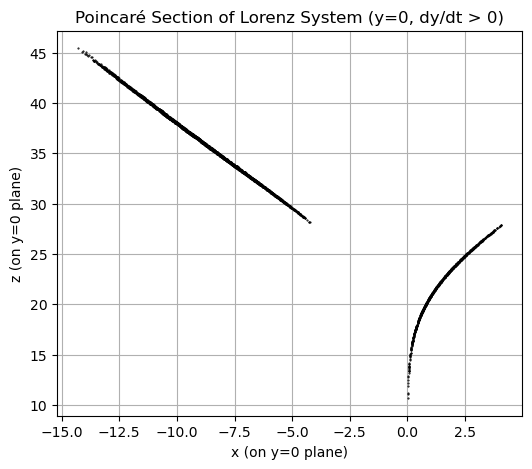

In [18]:
# Plot Poincaré section
plt.figure(figsize=(6, 5))
plt.plot(poincare_points_0[:, 0], poincare_points_0[:, 1], 'k.', markersize=1)
plt.xlabel("x (on y=0 plane)")
plt.ylabel("z (on y=0 plane)")
plt.title("Poincaré Section of Lorenz System (y=0, dy/dt > 0)")
plt.grid(True)
plt.show()

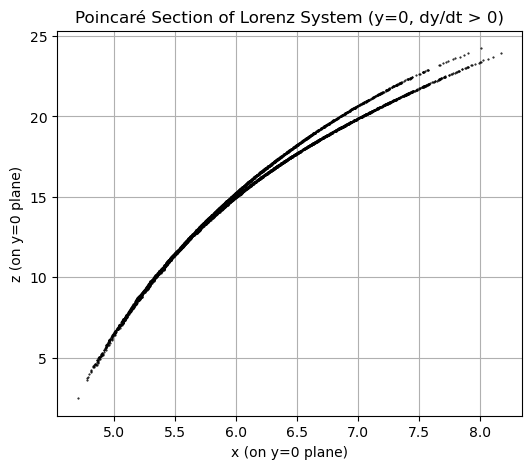

In [20]:
# Plot Poincaré section
plt.figure(figsize=(6, 5))
plt.plot(poincare_points_p10[:, 0], poincare_points_p10[:, 1], 'k.', markersize=1)
plt.xlabel("x (on y=0 plane)")
plt.ylabel("z (on y=0 plane)")
plt.title("Poincaré Section of Lorenz System (y=0, dy/dt > 0)")
plt.grid(True)
plt.show()

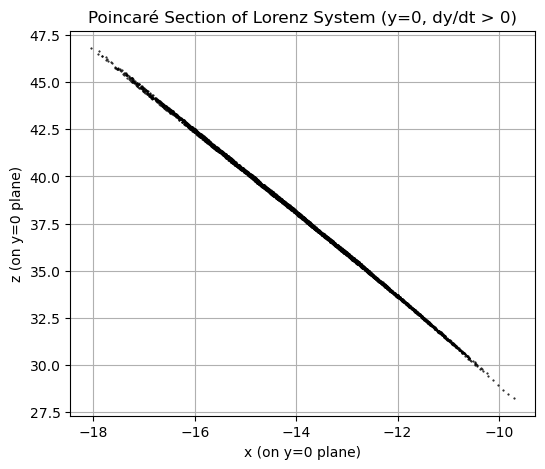

In [22]:
# Plot Poincaré section
plt.figure(figsize=(6, 5))
plt.plot(poincare_points_m10[:, 0], poincare_points_m10[:, 1], 'k.', markersize=1)
plt.xlabel("x (on y=0 plane)")
plt.ylabel("z (on y=0 plane)")
plt.title("Poincaré Section of Lorenz System (y=0, dy/dt > 0)")
plt.grid(True)
plt.show()

In [25]:
def find_UPO_P1(poincare_points):
    x = poincare_points[:,0]
    z = poincare_points[:,1]

    dist = np.sqrt( (x[1:] - x[:-1])**2 + ( z[1:] - z[:-1])**2 )
    indx = np.argmin(dist)
    xs = x[indx]
    zs = z[indx]

    return xs, zs

In [27]:
xs_0, zs_0 = find_UPO_P1(poincare_points_0)
xs_p10, zs_p10 = find_UPO_P1(poincare_points_p10)
xs_m10, zs_m10 = find_UPO_P1(poincare_points_m10)

In [28]:
print(xs_0, zs_0)
print(xs_p10, zs_p10)
print(xs_m10, zs_m10)

-10.442363160376017 38.6654349723073
5.668506831640417 12.773899070549412
-14.698205290234075 39.573219281709065


### Estimate the matrices

In [29]:
def next_poincare_return(x0, t_max=10):
    t_eval = np.linspace(0, t_max, 10000)
    sol = solve_ivp(lorenz, [0, t_max], x0, t_eval=t_eval, args=(rho0, sigma0, beta0,), rtol=1e-9, atol=1e-12)
    x, y, z = sol.y

    for i in range(1, len(y)):
        if y[i-1] < 0 and y[i] >= 0:
            alpha = -y[i-1] / (y[i] - y[i-1])
            x_cross = x[i-1] + alpha * (x[i] - x[i-1])
            z_cross = z[i-1] + alpha * (z[i] - z[i-1])
            return np.array([x_cross, z_cross])
    return None

In [30]:
delta = 1e-5

# Perturb in x direction
xp = np.array([xs + delta, 0.0, zs])
xm = np.array([xs - delta, 0.0, zs])
fxp = next_poincare_return(xp)
fxm = next_poincare_return(xm)

# Perturb in z direction
zp = np.array([xs, 0.0, zs + delta])
zm = np.array([xs, 0.0, zs - delta])
fzp = next_poincare_return(zp)
fzm = next_poincare_return(zm)

# Compute Jacobian (central difference)
df_dx = (fxp - fxm) / (2 * delta)
df_dz = (fzp - fzm) / (2 * delta)
A = np.column_stack((df_dx, df_dz))

In [31]:
A

array([[ 1.47107484, -5.06126547],
       [-2.52024495,  8.67351796]])

### Estimate B

In [39]:
# Estimate B = df/d(rho)
def next_return_given_rho(rho_value):
    def lorenz_rho(t, state):
        x, y, z = state
        dxdt = sigma * (y - x)
        dydt = x * (rho_value - z) - y
        dzdt = x * y - beta * z
        return [dxdt, dydt, dzdt]
    
    def return_map(x0):
        t_eval = np.linspace(0, 10, 10000)
        sol = solve_ivp(lorenz_rho, [0, 10], x0, t_eval=t_eval, rtol=1e-9, atol=1e-12)
        x, y, z = sol.y
        for i in range(1, len(y)):
            if y[i-1] < 0 and y[i] >= 0:
                alpha = -y[i-1] / (y[i] - y[i-1])
                x_cross = x[i-1] + alpha * (x[i] - x[i-1])
                z_cross = z[i-1] + alpha * (z[i] - z[i-1])
                return np.array([x_cross, z_cross])
        return None

    return return_map([xs, 0.0, zs])

# Finite difference approximation of B
delta_rho = 1e-5
f_plus = next_return_given_rho(rho + delta_rho)
f_minus = next_return_given_rho(rho - delta_rho)
B = (f_plus - f_minus) / (2 * delta_rho)
B = np.expand_dims(B, -1)
print("Estimated sensitivity matrix B:")
print(B)


Estimated sensitivity matrix B:
[[  7.56144868]
 [-12.14730047]]


## Eigen Values and Vectors

In [36]:
eigvals, eigvecs = np.linalg.eig(A)
eigvals

array([3.71174848e-04, 1.01442216e+01])

In [41]:
vu = np.expand_dims(eigvecs[:,1], -1)

In [40]:
np.shape(A), np.shape(B), np.shape(vu)

((2, 2), (2, 1), (2,))

In [42]:
def control(dzn, J, vus, s):
    c = np.dot(vu.T, s*vu - np.dot(J, dzn)).item()/np.dot(vu.T, B).item()
    return c

In [ ]:
x = np.zeros(N)
y = np.zeros(N)
z = np.zeros(N)
rho = np.ones(N) * rho0

N = 2000
for n in range(N-1):
    dzn = np.zeros([2,1])
    dzn[0] = x[n] - xs
    dzn[1] = y[n] - ys
    dist = np.sqrt( (x[n] - xs)**2 + (y[n] - ys)**2 )
    print(dist)
    if dist < epsilon:
        c = control(dzn, J, vs, s)
        a[n + 1] = a0 + c
    
    t_span = (0, dt)
    t_eval = np.linspace(*t_span, 1)
    x0 = [x[n], y[n], z[n]]
    
    sol = solve_ivp(lorenz, t_span, x0, t_eval=t_eval, args=(rho0, sigma0, beta0,))
    x, y, z = sol.y  

In [63]:
def control(dzn, J, vu, s):
    c = np.dot(vu.T, s*vu - np.dot(J, dzn)).item()/np.dot(vu.T, B).item()
    return c

In [55]:
def ogy_control(x_current):
    dx = x_current - np.array([x_star, z_star])
    numerator = c.T @ (A @ dx)
    denominator = c.T @ B
    u = - numerator / denominator
    return np.clip(u, -1.0, 1.0)  # limit control for physical realism

In [56]:
x_star = xs
z_star = zs

In [66]:
xs

-10.442363160376017

In [77]:
t_span, t_eval

((0, 0.01), array([0.  , 0.01]))

In [86]:
rho.item()

28.659111182388557

In [113]:
s = 0.0

In [220]:
dt = 0.0001
T = 10
x0 = np.array([xs, 0, zs])
active = []

x = np.zeros([int(T//dt), 3])
x[0] = x0
N = int(T//dt)
for n in range(N-1):
    if n%10000 == 0:
        print(n)
    t_span = (0, dt)
    t_eval = [0, dt]
    x[n+1] = solve_ivp(lorenz, t_span, np.array(x[n]), t_eval=t_eval, args=(rho, sigma0, beta0,)).y[:,1]
    
    dist = np.sqrt((x[n+1, 0] - xs)**2 + (x[n+1, 1] - ys)**2 + (x[n+1, 2] - zs)**2)
    dzn = np.zeros([2,1])
    dzn[0] = x[n+1, 0] - xs
    dzn[1] = x[n+1, 2] - zs
    if dist < 2:
        if x[n, 1] < 0 and x[n+1, 1] > 0:
            rho = rho0 + control(dzn, A, vu, s)
            active.append(n)
            print(rho, rho0, n)
        else:
            rho = rho0
    else:
        rho = rho0


0
10000
20000
28.570292436100363 28 23246
30000
40000
50000
60000
27.131590595242848 28 60962
70000
80000
90000


In [214]:
sol_upo = solve_ivp(lorenz, (0, 10), np.array([xs, ys, zs]), t_eval=np.arange(0, 10, 0.0001), args=(rho0, sigma0, beta0,)).y

In [215]:
np.shape(sol_upo)

(3, 100000)

### Checking code

In [195]:
dt = 0.0001
T = 10
x0 = np.array([xs, 0, zs])
active = []

x = np.zeros([int(T//dt), 3])
x[0] = x0
N = int(T//dt)
for n in range(N-1):
    t_span = (0, dt)
    t_eval = [0, dt]
    x[n+1] = solve_ivp(lorenz, t_span, np.array(x[n]), t_eval=t_eval, args=(rho0, sigma0, beta0,)).y[:,1]

In [217]:
dist = np.sqrt((x[:,0] - xs)**2 + (x[:, 1] - ys)**2 + (x[:, 2] - zs)**2)

(0.0, 5.0)

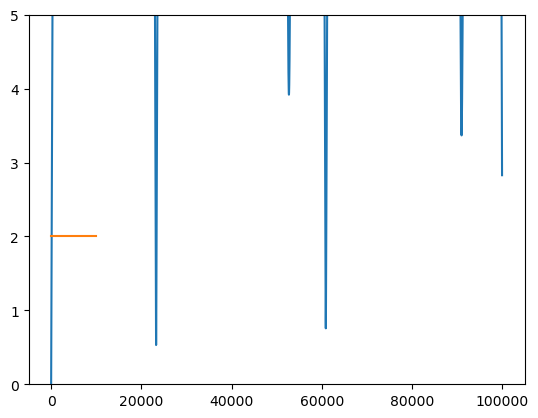

In [219]:
plt.plot(dist)
plt.plot([0, 10000], [2,2])
plt.ylim(0, 5)

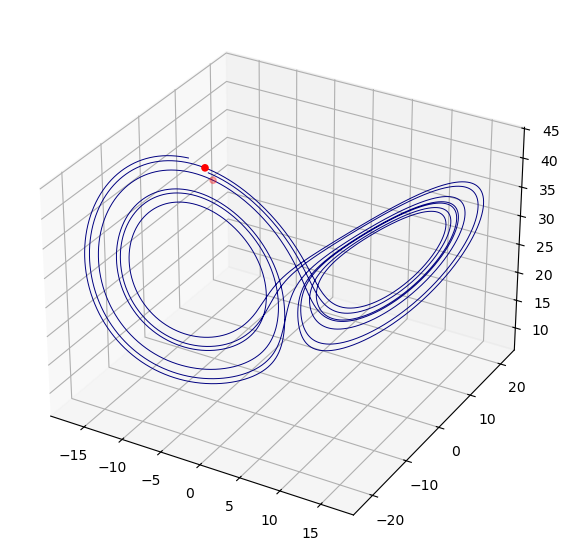

In [222]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Plot the trajectory
# ax.scatter(xs+0.2, 0, zs+0.2, color='red')
# ax.plot(x[:800000, 0], x[:800000, 1], x[:800000, 2], lw=0.7, color='navy')
ax.plot(x[:, 0], x[:, 1], x[:, 2], lw=0.7, color='navy')
ax.scatter(x[np.array(active), 0], x[np.array(active), 1], x[np.array(active), 2], color='red')

In [224]:
A

array([[ 1.47107484, -5.06126547],
       [-2.52024495,  8.67351796]])

In [225]:
B

array([[  7.56144868],
       [-12.14730047]])

In [223]:
xs, zs

(-10.442363160376017, 38.6654349723073)

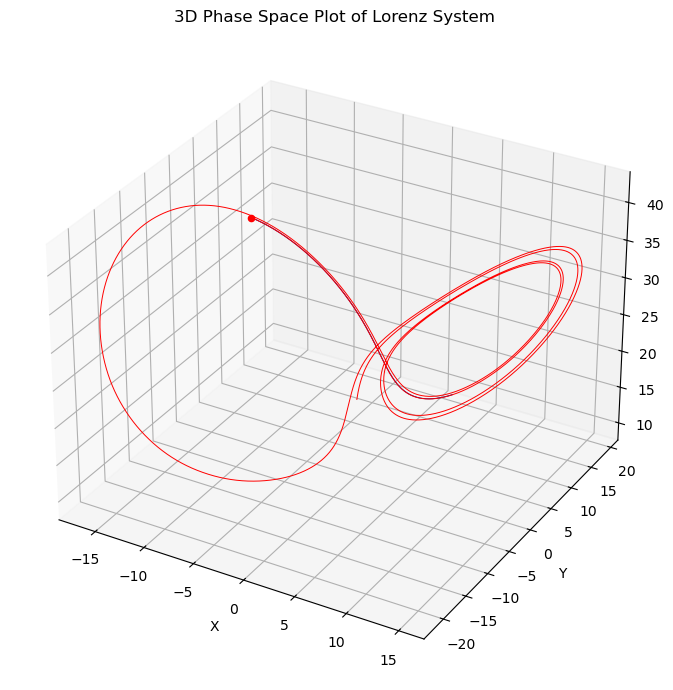

In [203]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Plot the trajectory
# ax.scatter(xs+0.2, 0, zs+0.2, color='red')
ax.plot(x[:40000, 0], x[:40000, 1], x[:40000, 2], lw=0.7, color='navy')
ax.scatter(xs, ys, zs, color='red')
# ax.scatter(x[np.array(active), 0], x[np.array(active), 1], x[np.array(active), 2], color='red')
ax.plot(sol_upo[0, :40000], sol_upo[1, :40000], sol_upo[2, :40000], lw=0.7, color='red')

# Customize axes
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Phase Space Plot of Lorenz System')

plt.tight_layout()
plt.show()


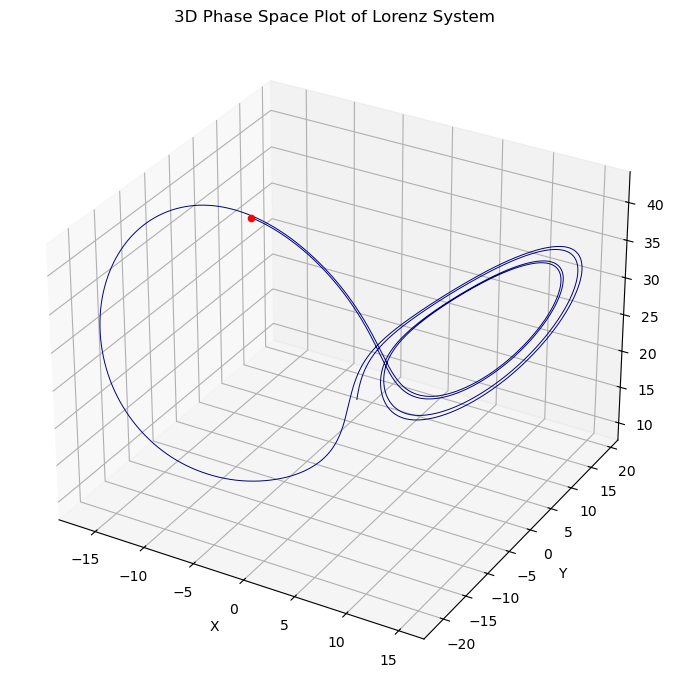

In [194]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Plot the trajectory
# ax.plot(sol_upo[0, :23100], sol_upo[1, :23100], sol_upo[2, :23100], lw=0.7, color='navy')
ax.plot(sol_upo[0, :40000], sol_upo[1, :40000], sol_upo[2, :40000], lw=0.7, color='navy')
ax.scatter(xs, ys, zs, color='red')

# Customize axes
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Phase Space Plot of Lorenz System')

plt.tight_layout()
plt.show()


In [61]:
rho_base = rho  # default rho

# Controlled simulation
dt = 0.01
T = 100
N = int(T / dt)
x = np.array([1.0, 1.0, 1.0])
trajectory = []

for step in range(N):
    # RK4 step
    def lorenz_rho_control(t, state):
        return lorenz(t, state, rho, sigma, beta)
    
    y_prev = x[1]
    print(x)
    k1 = dt * np.array( lorenz_rho_control(0, x) ) 
    k2 = dt * np.array( lorenz_rho_control(0, x + 0.5 * k1) )
    k3 = dt * np.array( lorenz_rho_control(0, x + 0.5 * k2) )
    k4 = dt * np.array( lorenz_rho_control(0, x + k3) )
    x = x + (k1 + 2*k2 + 2*k3 + k4) / 6

    # Apply control at section crossing
    if y_prev < 0 and x[1] >= 0:
        xp = np.array([x[0], x[2]])
        if np.linalg.norm(xp - np.array([x_star, z_star])) < 1.0:
            u = ogy_control(xp)
            rho = rho_base + u
        else:
            rho = rho_base  # no control far from UPO
    
    trajectory.append(x.copy())

trajectory = np.array(trajectory)

# Plot controlled trajectory
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot(trajectory[:, 0], trajectory[:, 1], trajectory[:, 2])
ax.set_title("OGY-Controlled Lorenz Trajectory")
plt.show()


[1. 1. 1.]


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (3,) + inhomogeneous part.

In [5]:
xs = (-0.7 + np.sqrt(0.7**2 + 4*1.4))/(2*1.4)
ys = 0.3*xs

In [6]:
xs, ys

(0.6313544770895047, 0.1894063431268514)

In [7]:
xi, yi = xs, ys
for i in range(100):
    xi, yi = Henon_Map([xi, yi], a0, b)

In [8]:
xi, yi

(0.6313544770895048, 0.18940634312685142)

In [9]:
J = np.array( [[-2 * a0 * xs, 1], [b, 0] ])
df_da = np.array([[-xs**2], [0]])
B = df_da

In [10]:
eigvals, eigvecs = np.linalg.eig(J)

In [11]:
eigvals, eigvecs

(array([-1.92373886,  0.15594632]),
 array([[-0.98805776, -0.46122777],
        [ 0.15408397, -0.88728178]]))

In [29]:
vs = np.expand_dims(eigvecs[:,0], -1)
vu = np.expand_dims(eigvecs[:,1], -1)

In [30]:
np.shape(B), np.shape(vs)

((2, 1), (2, 1))

In [31]:
B*vs

array([[0.3938482],
       [0.       ]])

In [32]:
np.dot(vs.T, B)[0]

array([0.3938482])

In [60]:
dzn = np.ones([2,1])
s = 0.05

In [61]:
np.shape(np.dot(J, dzn)), np.shape(vs), np.shape(vs.T)

((2, 1), (2, 1), (1, 2))

In [62]:
def control(dzn, J, vs, s):
    c = np.dot(vs.T, s*vs - np.dot(J, dzn)).item()/np.dot(vs.T, B).item()
    return c

In [63]:
x = np.zeros(N)
y = np.zeros(N)
a = np.ones(N) * a0

N = 2000
for n in range(N-1):
    dzn = np.zeros([2,1])
    dzn[0] = x[n] - xs
    dzn[1] = y[n] - ys
    dist = np.sqrt( (x[n] - xs)**2 + (y[n] - ys)**2 )
    print(dist)
    if dist < epsilon:
        c = control(dzn, J, vs, s)
        a[n + 1] = a0 + c
    
    x[n + 1] = 1 - a[n + 1] * x[n] ** 2 + y[n]
    y[n + 1] = b * x[n]    

0.6591534256587372
0.4144566133850914
1.0372670892075682
0.5417028024770398
1.3787091399020188
0.41881739665116574
0.28474220067167305
0.3756100625067893
0.92575420593551
0.6168577741226172
1.6856073694342923
0.9523092075265001
0.24278919343183958
0.2619821236788942
0.378535245781131
0.9317832452736384
0.6145475517719511
1.6758204132471177
0.9276424372799996
0.23581940522211733
0.28195040065128646
0.40387221624552166
1.0080288036509704
0.5706128418407608
1.4947116188444924
0.5508041797736192
0.09920486278463438
0.05984468884719467
0.09545636449065178
0.1979396656064142
0.32609317612975997
0.7758269373838362
0.6685849584451751
1.9005940286124599
1.5812861972538454
1.1010610699530767
0.31373418006136544
0.16653800752766537
0.23335727738440845
0.5298325535384746
0.6307655167422387
1.7690509174219027
1.1668581008509282
0.3731098646489485
0.062019116157567916
0.044830102707624324
0.04017851742047127
0.0435678757539983
0.04209937535197962
0.04281517450574907
0.04247554218037088
0.04263808294

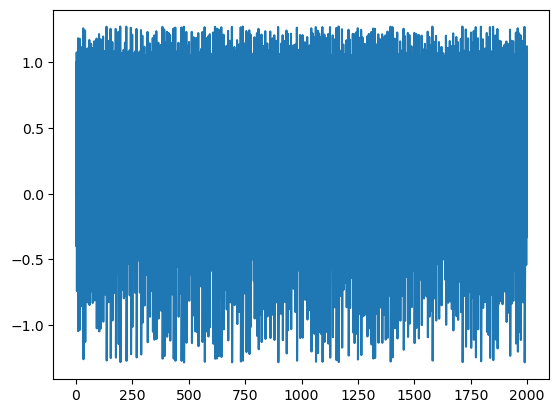

In [59]:
plt.plot(x)

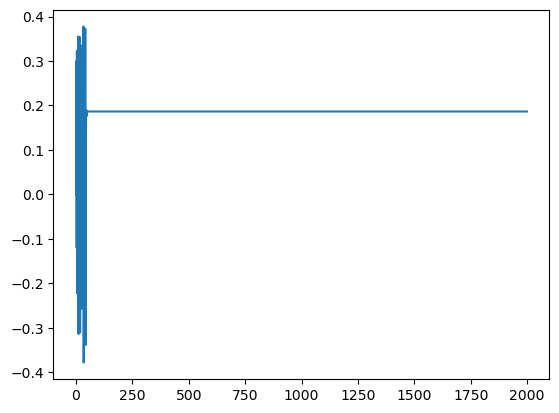

In [54]:
plt.plot(y)

In [ ]:
# Step 2: Initialize arrays
x = np.zeros(N)
y = np.zeros(N)
a = np.ones(N) * a0

# Initial condition
x[0], y[0] = 0.1, 0.1

# Step 3: OGY control loop
for n in range(N - 1):
    # Check distance to UPO
    dist = np.sqrt((x[n] - x_star) ** 2 + (y[n] - y_star) ** 2)

    if dist < epsilon:
        # Linearized Jacobian at fixed point
        J = np.array([
            [-2 * a[n] * x_star, 1],
            [b, 0]
        ])
        # Derivative of map w.r.t. a
        df_da = np.array([-x_star ** 2, 0])

        # Stabilize the unstable direction
        eigvals, eigvecs = np.linalg.eig(J)
        unstable_index = np.argmax(np.abs(eigvals))
        v_u = eigvecs[:, unstable_index].real

        # Feedback control law: delta_a = -K * projection of deviation onto unstable direction
        delta = np.array([x[n] - x_star, y[n] - y_star])
        delta_proj = np.dot(delta, v_u)
        control = -K * delta_proj / np.dot(df_da, v_u)
        a[n + 1] = a0 + control
    else:
        a[n + 1] = a0  # No control

    # Apply map
    x[n + 1] = 1 - a[n + 1] * x[n] ** 2 + y[n]
    y[n + 1] = b * x[n]


Using fixed point: x* = 0.4643, y* = 0.1393


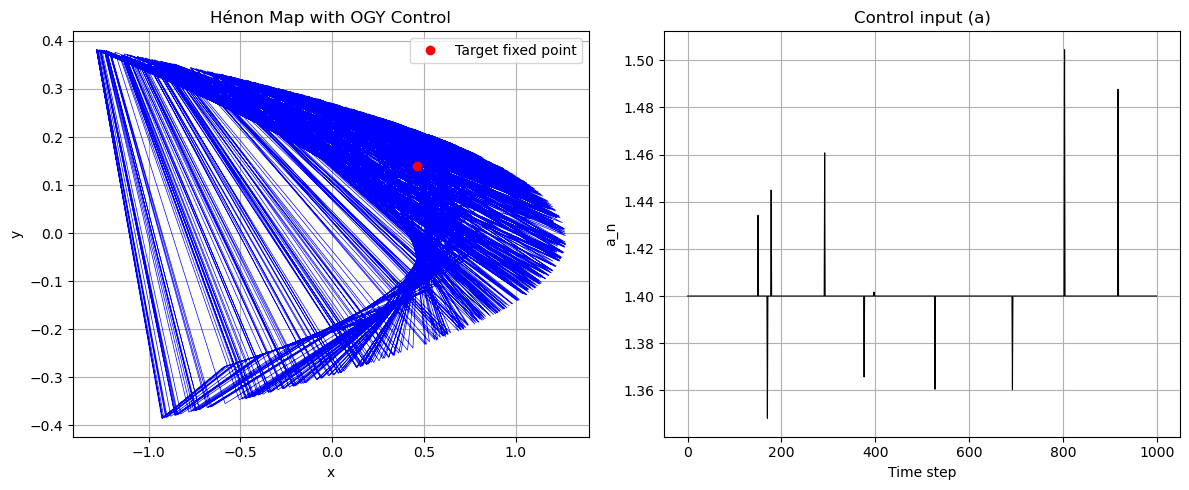

In [3]:
# Step 4: Plotting results
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(x, y, 'b-', lw=0.5)
plt.plot(x_star, y_star, 'ro', label='Target fixed point')
plt.title('Hénon Map with OGY Control')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(a, 'k-', lw=0.8)
plt.title("Control input (a)")
plt.xlabel('Time step')
plt.ylabel('a_n')
plt.grid(True)

plt.tight_layout()
plt.show()


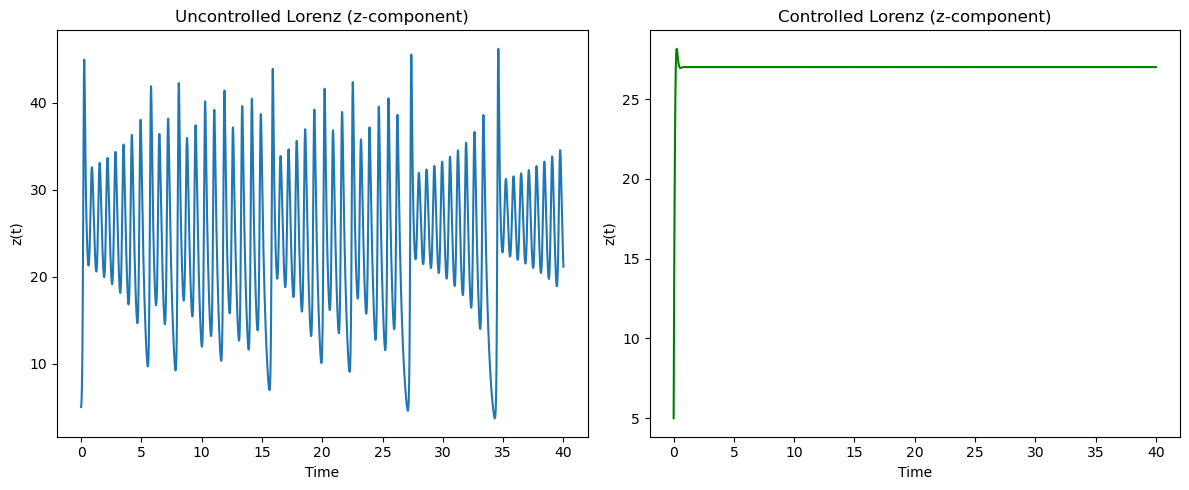

In [5]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Parameters
sigma = 10
beta = 8 / 3
rho = 28  # Chaotic for rho > 24.74

# Equilibrium point near origin
x_eq = np.array([np.sqrt(beta * (rho - 1)), np.sqrt(beta * (rho - 1)), rho - 1])

# Linear gain matrix (tuned manually)
K = np.diag([10, 10, 10])  # Stronger gains = stronger control

def lorenz_controlled(t, state):
    x, y, z = state
    state_vec = np.array([x, y, z])
    # Control input
    u = -K @ (state_vec - x_eq)
    # Lorenz dynamics with control
    dxdt = sigma * (y - x) + u[0]
    dydt = x * (rho - z) - y + u[1]
    dzdt = x * y - beta * z + u[2]
    return [dxdt, dydt, dzdt]

# For comparison: uncontrolled Lorenz system
def lorenz_uncontrolled(t, state):
    x, y, z = state
    dxdt = sigma * (y - x)
    dydt = x * (rho - z) - y
    dzdt = x * y - beta * z
    return [dxdt, dydt, dzdt]

# Initial state
x0 = [5, 5, 5]
t_span = (0, 40)
t_eval = np.linspace(*t_span, 10000)

# Simulate controlled
sol_controlled = solve_ivp(lorenz_controlled, t_span, x0, t_eval=t_eval)
sol_uncontrolled = solve_ivp(lorenz_uncontrolled, t_span, x0, t_eval=t_eval)

# Plot
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(sol_uncontrolled.t, sol_uncontrolled.y[2], label='Uncontrolled')
plt.title("Uncontrolled Lorenz (z-component)")
plt.xlabel("Time")
plt.ylabel("z(t)")

plt.subplot(1, 2, 2)
plt.plot(sol_controlled.t, sol_controlled.y[2], label='Controlled', color='green')
plt.title("Controlled Lorenz (z-component)")
plt.xlabel("Time")
plt.ylabel("z(t)")

plt.tight_layout()
plt.show()
